# Deep embedding clustering

Se comparan los métodos de clustering espacial utilizados en la literatura con el método DEC propuesto por Xie y co. 2016. Originalmente esta metodología no sigue restricciones espaciales que fueron agregadas a los fines de  este trabajo.

In [1]:
from lectura_datos import *
import regionalizacion as reg
import matplotlib.pyplot as plt
import deep_cluster as dc
from sklearn.cluster import KMeans, AgglomerativeClustering
import pickle 
import copy
dir_datos = "datos"

%matplotlib inline
%load_ext autoreload
%autoreload 2

Can't load requested DLL: C:\Program Files\GeoDa Software\ogr_FileGDB.dll
126: The specified module could not be found.

Can't load requested DLL: C:\Program Files\GeoDa Software\ogr_FileGDB.dll
126: The specified module could not be found.

Can't load requested DLL: C:\Program Files\GeoDa Software\ogr_MSSQLSpatial.dll
126: The specified module could not be found.

Can't load requested DLL: C:\Program Files\GeoDa Software\ogr_MSSQLSpatial.dll
126: The specified module could not be found.

Can't load requested DLL: C:\Program Files\GeoDa Software\ogr_OCI.dll
126: The specified module could not be found.

Can't load requested DLL: C:\Program Files\GeoDa Software\ogr_OCI.dll
126: The specified module could not be found.

Can't load requested DLL: C:\Program Files\GeoDa Software\ogr_PG.dll
126: The specified module could not be found.

Can't load requested DLL: C:\Program Files\GeoDa Software\ogr_PG.dll
126: The specified module could not be found.

Can't load requested DLL: C:\Program Fil

In [2]:
covid,geo, centroides, codiprov,covid_acum,personas = df_covid()

El mes desde el cuál todos los dptos tienen al menos 1 contagiado es: 2021-01


## Armado de regiones

Se forman 6 regiones que van a tener comportamientos diferentes entre sí. Dentro de cada región los departamentos tienen el mismo comportamiento de base.

In [3]:
codiprov.groupby('provincia').describe()

regiones = {'noroeste' : ('Jujuy','Salta','Tucumán','Santiago del Estero','Catamarca'),
            'noreste'  : ('Formosa', 'Chaco', 'Misiones','Corrientes','Santa Fe','Entre Ríos'),
            'cuyo' : ('La Rioja','San Juan','Mendoza','San Luis'),
            'pampeana' : ('Córdoba', 'La Pampa', 'Buenos Aires','Ciudad Autónoma de Buenos Aires' ),
            'patagonia' : ('Neuquén', 'Río Negro', 'Chubut', 'Santa Cruz', 'Tierra del Fuego')    
    }


lista_regiones = []
errores = []
for i in range(len(codiprov)):
    prov = codiprov.iloc[i].provincia
    j = 1
    pertenece = False
    for k in regiones.keys():
        l = regiones[k]
        if prov in l:
            lista_regiones.append(j)
            pertenece = True
        else:
        
            pass
        j += 1
    if pertenece == False:
        errores.append(codiprov.iloc[i]) 


cov =  covid.loc[pd.IndexSlice[:,'2021-01'],:].copy()
cov['reg'] = lista_regiones

regiones = cov.reg.copy()
regiones[cov.provincia == "Tucumán"] = 6
cov['reg'] = regiones

El comportamiento de cada región va estar dado por una función base que depende del periodo de tiempo, en esta caso son funciones cuadráticas que la única variación que tienen entre regiones es el valor máximo y el periodo en que llegan al mismo. Se considera el comportamiento de dos variables por cada departamento. Dado el problema que tenemos lo que se va modificando es la tasa de proporción de la población de cada departamento.

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
pipe = Pipeline([('standard', StandardScaler())#,
                 #('normalizer', Normalizer('l1'))
                 ])

func = {1 : lambda x : 0.14-((x-50)/100)**2,
     2 : lambda x : 0.25-((x-30)/100)**2,
     3 : lambda x : 0.20-((x-80)/100)**2,
     4 : lambda x : 0.10-((x-50)/100)**2,
     5 : lambda x : 0.3-((x-50)/100)**2,
     6 : lambda x : 0.3-((x-50)/100)**2
     }

x = cov.reg.map(func)


func2 = {1 : lambda x : 0.14-((2*x-90)/160)**2,
     2 : lambda x : 0.25-((2*x-100)/160)**2,
     3 : lambda x : 0.20-((2*x-150)/160)**2,
     4 : lambda x : 0.20-((2*x-100)/160)**2,
     5 : lambda x : 0.15-((2*x-120)/160)**2,
     6 : lambda x : 0.3-((2*x-120)/160)**2
     }

x2 = cov.reg.map(func2)

Para agregar ruido al modelo, por cada departamento se le agega un componente aleatorio que proviene de una distribución uniforme con intérvalo $[a,b) con b > a$ pero como se trata de proporciones se controla que dicho valor no sea menor a 0. Por lo tanto la fórmula de la proporción por departamento queda asi:

$x_t = f_R(t) + (b-a)*rand + a $

$y_t = x_t, si x_t > 0 $

$y_t = 0; en caso contrario$

siendo $f_R(t)$  la función de la resgión a la que pertenece el área.


En este primer caso tomamos el modelo más sencillo dónde no existe el componente aleatorio

In [5]:
np.random.seed(3264)

def genera_datos(periodos,amplitud):
  periodos = periodos
  p = np.arange(0,periodos)
  varianz = amplitud

  val = []
  for i in x:
      y = i(p)+(np.random.rand()-0.5)*varianz
      val.append(y)
  val = np.array(val)

  val2 = []
  for i in x2:
      y = i(p)+(np.random.rand()-0.5)*varianz
      val2.append(y)
  val2 = np.array(val2)
  v = np.c_[(val * (val > 0)),(val2 * (val2 > 0))] 


  var = v*cov[['personas']].values
  l = list(zip(['var1']*periodos,p))
  l.extend(list(zip(['var2']*periodos,p)))
  l = tuple(l)
  var = pd.DataFrame(var, columns = pd.MultiIndex.from_tuples(l), index = cov.index) 
  var_ = var.stack()
  var_['personas'] = np.array([cov.personas.values,]*periodos).T.reshape(525*periodos,1)
  var = var_.droplevel('mes')
  var = gpd.GeoDataFrame(var, geometry = np.array([cov.geometry.values,]*periodos).T.reshape(525*periodos,))
  var.head()

  sim4 = reg.entorno(var,['var1','var2'],'personas', pipe)
  sim4.procesar_datos()
  #param = {'n_clusters' : [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]} #se crean los distintos parametros para probar, en este caso solo de cantidad de grupos
  param = {'n_clusters' : [6]} 
  metricas = {'hg': sim4.metric.Hg_relat, 'ind lq': sim4.metric.indice_lq} # se crean las metricas. En este caso las que provienen del LQ y es importante que salgan del entorno así buscan bien los datos
  param_aglo = reg.copy(param)
  param_aglo['connectivity'] = [sim4.W.sparse]

  sim4.agregar_metodo('km', KMeans(), param, metricas)
  sim4.agregar_metodo('aglo', AgglomerativeClustering(), param, metricas)
  sim4.agregar_metodo('aglo_esp', AgglomerativeClustering(), param_aglo, metricas)

  sim4.agregar_data('prop', v, ajustar = False)
  sim4.agregar_data('prop1', sim4.dic['prop'][:,:periodos], ajustar = False)
  sim4.agregar_data('prop2', sim4.dic['prop'][:,periodos:], ajustar = False)

  return sim4,l
sim4,l = genera_datos(100,0)

C:\Anaconda3\envs\covid2\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  warnings.warn(message)
C:\Anaconda3\envs\covid2\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  warnings.warn(message)
C:\Anaconda3\envs\covid2\lib\site-packages\sklearn\utils\extmath.py:985: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Anaconda3\envs\covid2\lib\site-packages\sklearn\utils\extmath.py:990: RuntimeWarning: invalid value encountered in true_divide
  T = new_sum / new_sample_count
C:\Anaconda3\envs\covid2\lib\site-packages\sklearn\utils\extmath.py:1020: RuntimeWarning: invalid value encountered in true_divide
  new_unnormalized_variance -= correction ** 2 / new_sample_count


In [6]:
dir_general = "Geodabd/"

<AxesSubplot:>

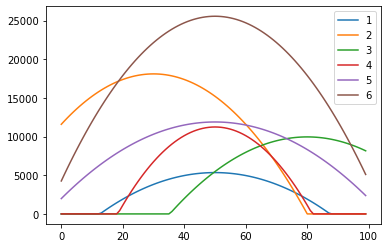

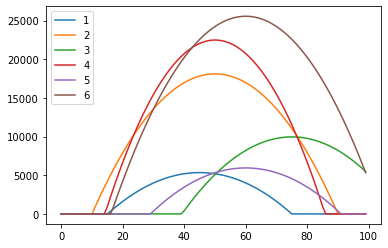

In [7]:
sim4.df = sim4.convertir_a_df(sim4.panel_df, ['var1','var2'])
df = sim4.df.groupby(regiones.values).mean()
sim4.df = gpd.GeoDataFrame(sim4.df, geometry = sim4.geo.values)
df['var1'].T.plot(),
df['var2'].T.plot()

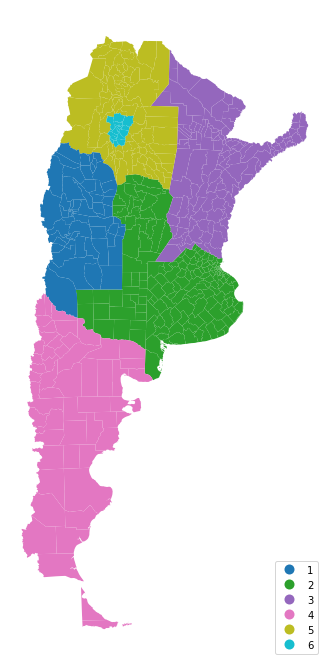

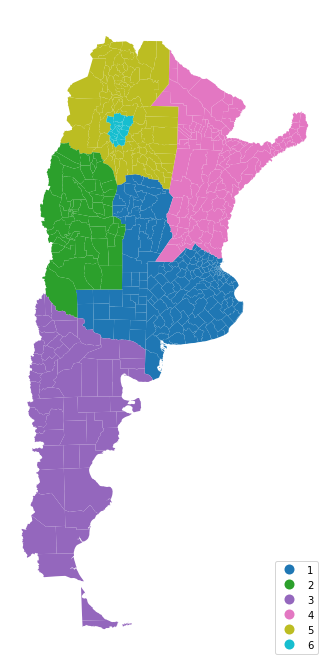

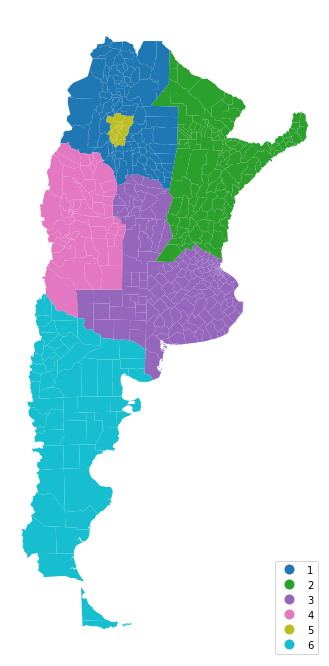

(None, None, None)

In [8]:
np.random.seed(646)

lista = ['prop1','prop2']
n_enc = 4

sim4.calcular_metodo('km', lista, centroides = False,ae = True, n_encoders = n_enc, optimizer = 'adam', loss = 'cosine_similarity')
sim4.calcular_metodo('aglo', lista, centroides = False,ae = True, n_encoders = n_enc, optimizer = 'adam', loss = 'cosine_similarity')
sim4.calcular_metodo('aglo_esp', lista, centroides = False,ae = True, n_encoders = n_enc, optimizer = 'adam', loss = 'cosine_similarity')
sim4.mapa('km'),sim4.mapa('aglo'),sim4.mapa('aglo_esp')

In [9]:
ent = sim4
dir_ent = "sim4/"

geoprop = reg.gpd.GeoDataFrame(ent.retornar_dfs(separado = [lista])[0],columns = [l[i][0]+str(l[i][1]) for i in range(len(l))] ,geometry = ent.geo.values)
geoprop.to_file(dir_general+dir_ent+"prop.shp")
geoenco = reg.gpd.GeoDataFrame(ent.enco.predict(ent.retornar_dfs(separado = lista)), columns = ['enco'+str(i) for i in range(n_enc)], geometry = ent.geo.values)
geoenco.to_file(dir_general+dir_ent+"encoders.shp")

C:\Anaconda3\envs\covid2\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
C:\Anaconda3\envs\covid2\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [10]:
rdos_rgeoda = gpd.read_file("Geodabd/sim4/rdos_rgeod.shp")
rdos_rgeoda.head()

,enco0,enco1,enco2,enco3,ae_sk,ae_redcap,ae_schc,sk,redcap,geometry
0,0.947212,2.255413,4.665518,1.762755,1,1,1,1,1,"POLYGON ((4200350.769 6147470.664, 4201101.267..."
1,0.947212,2.255413,4.665518,1.762755,1,1,1,1,1,"POLYGON ((4198043.775 6148577.659, 4198111.775..."
2,0.947212,2.255413,4.665518,1.762755,1,1,1,1,1,"POLYGON ((4198450.276 6145157.669, 4198456.277..."
3,0.947212,2.255413,4.665518,1.762755,1,1,1,1,1,"POLYGON ((4201672.770 6142869.179, 4201695.770..."
4,0.947212,2.255413,4.665518,1.762755,1,1,1,1,1,"POLYGON ((4196342.782 6145516.166, 4196373.783..."


<AxesSubplot:>

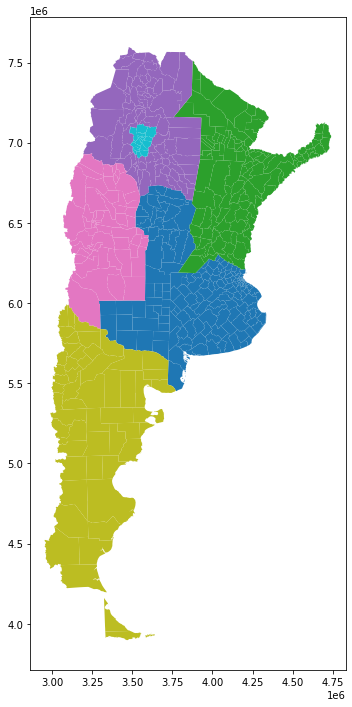

In [11]:
rdos_rgeoda.plot('ae_sk', categorical = True, figsize = (15,12))

In [12]:
X = sim4.retornar_dfs(separado = lista)
sdec_ = dc.sdec(6)
XX =np.c_[X[0],X[1]]
sdec_.gen_modelo()
sdec_.train_autoencoder(X, XX)
sdec_.ajustar_modelo(X, sim4.W.sparse)


delta_label  0.0 < tol  0.0001
Reached tolerance threshold. Stopping training.


<AxesSubplot:>

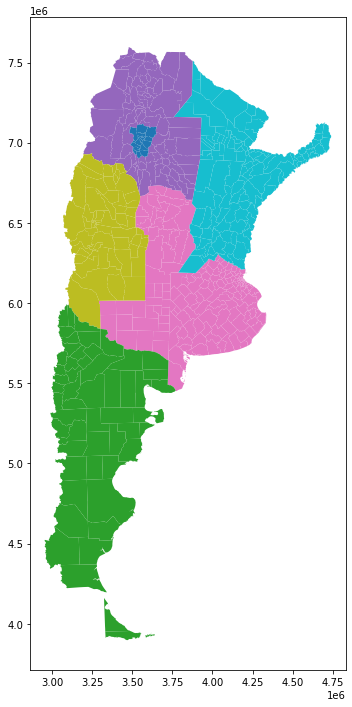

In [13]:
sim4.df.plot(sdec_.y_pred, categorical = True, figsize = (15,12))

In [14]:
sim4.metric.regiones = regiones.values
sim4.metric.MI(sim4.df,rdos_rgeoda.redcap.values),sim4.metric.MI(sim4.df,sdec_.y_pred),sim4.metric.MI(sim4.df,rdos_rgeoda.ae_redcap.values),sim4.metric.MI(sim4.df,rdos_rgeoda.ae_sk.values),sim4.metric.MI(sim4.df,rdos_rgeoda.sk.values)

(1.0, 1.0, 1.0, 1.0, 1.0)

In [15]:
sim4.metric.calc_metricas(XX, sdec_.y_pred)

,mi,ilq,hgr,sil,cal,dav
0,1.0,0.826,1.0,1.0,1.127719e+31,2.799367e+07


In [16]:
sim4.metric.Hg_relat(X, rdos_rgeoda.redcap.values),sim4.metric.Hg_relat(X, sdec_.y_pred),sim4.metric.Hg_relat(X, rdos_rgeoda.ae_redcap.values),sim4.metric.Hg_relat(X, rdos_rgeoda.ae_sk.values),sim4.metric.Hg_relat(X, rdos_rgeoda.sk.values)

(1.0, 1.0, 1.0, 1.0, 1.0)

In [17]:
sim4.metric.indice_lq(X, rdos_rgeoda.redcap.values),sim4.metric.indice_lq(X, sdec_.y_pred),sim4.metric.indice_lq(X, rdos_rgeoda.ae_redcap.values)

(0.8260000000000001, 0.8260000000000001, 0.8260000000000001)

Cómo se ve en este primer caso todos los algoritmos llegan al resultado perfecto. Así lo marcan las métricas de rendimiento también que tienen valores altos para todas las cálculadas. El índice LQ es el único que no llega a valor 1 como debíera marcar, pero este se calcula en base a intérvalos de confianza y  el resultado dado puede que no este bien separado en este sentido. 

Cabe aclarar que los algoritmos NO espaciales en este caso han funcionado bien pero porque no hay variabilidad y las regiones construidas son por esencia espaciales, en caso de que alguno de estos parámetros varíe encuentran resultados mucho más desordenados en el territorio

### Caso 2

En el segundo caso vamos a tomar una amplitud del espacio random de 0.5

In [18]:
np.random.seed(3264)

sim5,l = genera_datos(100,0.5)

C:\Anaconda3\envs\covid2\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  warnings.warn(message)
C:\Anaconda3\envs\covid2\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  warnings.warn(message)


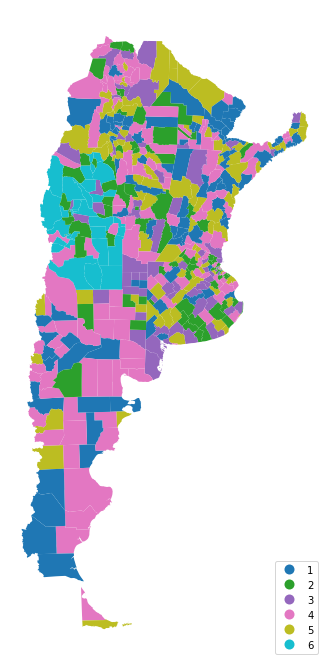

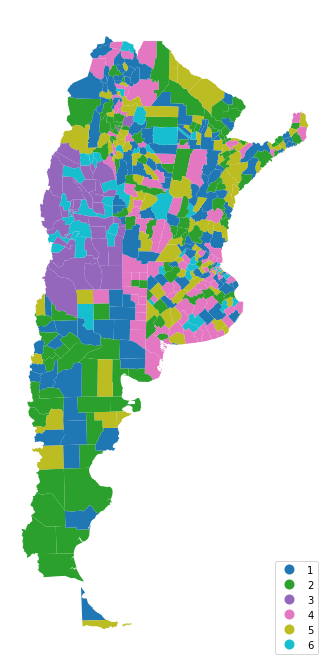

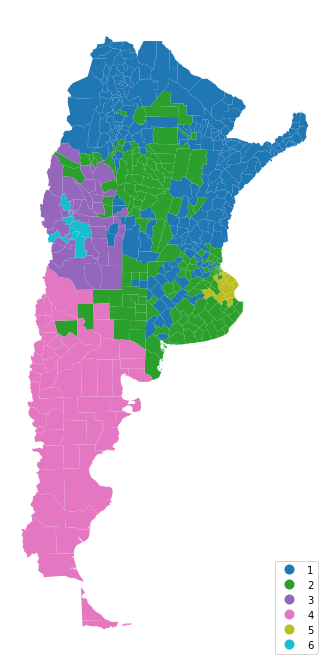

(None, None, None)

In [19]:
np.random.seed(646)

lista = ['prop1','prop2']
n_enc = 4

sim5.calcular_metodo('km', lista, centroides = False,ae = True, n_encoders = n_enc, optimizer = 'adam', loss = 'cosine_similarity')
sim5.calcular_metodo('aglo', lista, centroides = False,ae = True, n_encoders = n_enc, optimizer = 'adam', loss = 'cosine_similarity')
sim5.calcular_metodo('aglo_esp', lista, centroides = False,ae = True, n_encoders = n_enc, optimizer = 'adam', loss = 'cosine_similarity')
sim5.mapa('km'),sim5.mapa('aglo'),sim5.mapa('aglo_esp')

In [20]:
ent = sim5
dir_ent = "sim5/"

geoprop = reg.gpd.GeoDataFrame(ent.retornar_dfs(separado = [lista])[0],columns = [l[i][0]+str(l[i][1]) for i in range(len(l))] ,geometry = ent.geo.values)
geoprop.to_file(dir_general+dir_ent+"prop.shp")
geoenco = reg.gpd.GeoDataFrame(ent.enco.predict(ent.retornar_dfs(separado = lista)), columns = ['enco'+str(i) for i in range(n_enc)], geometry = ent.geo.values)
geoenco.to_file(dir_general+dir_ent+"encoders.shp")

C:\Anaconda3\envs\covid2\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
C:\Anaconda3\envs\covid2\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [21]:
rdos_rgeoda = gpd.read_file(dir_general+dir_ent+"rdos_rgeod.shp")
rdos_rgeoda.head()

,enco0,enco1,enco2,enco3,ae_sk,ae_redcap,ae_schc,sk,redcap,geometry
0,1.700958,0.891492,0.0,0.626976,6,3,1,1,3,"POLYGON ((4200350.769 6147470.664, 4201101.267..."
1,2.333167,2.049948,0.0,1.650553,2,3,1,1,1,"POLYGON ((4198043.775 6148577.659, 4198111.775..."
2,1.842927,1.065721,0.0,0.586798,6,3,1,1,3,"POLYGON ((4198450.276 6145157.669, 4198456.277..."
3,2.397116,2.236053,0.0,0.176558,2,3,1,1,3,"POLYGON ((4201672.770 6142869.179, 4201695.770..."
4,2.244087,2.163703,0.0,1.850841,2,3,1,1,1,"POLYGON ((4196342.782 6145516.166, 4196373.783..."


(<AxesSubplot:>, <AxesSubplot:>)

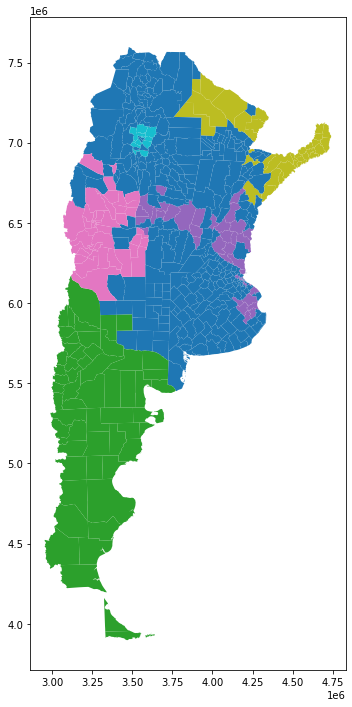

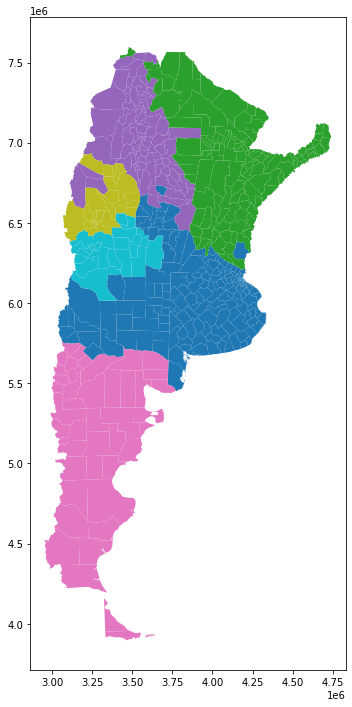

In [22]:
rdos_rgeoda.plot('redcap', categorical = True, figsize = (15,12)),rdos_rgeoda.plot('sk', categorical = True, figsize = (15,12))

In [23]:
X = sim5.retornar_dfs(separado = lista)
sdec_ = dc.sdec(6)
XX =np.c_[X[0],X[1]]
sdec_.gen_modelo()
sdec_.train_autoencoder(X, XX)
sdec_.ajustar_modelo(X, sim5.W.sparse)

delta_label  0.0 < tol  0.0001
Reached tolerance threshold. Stopping training.


<AxesSubplot:>

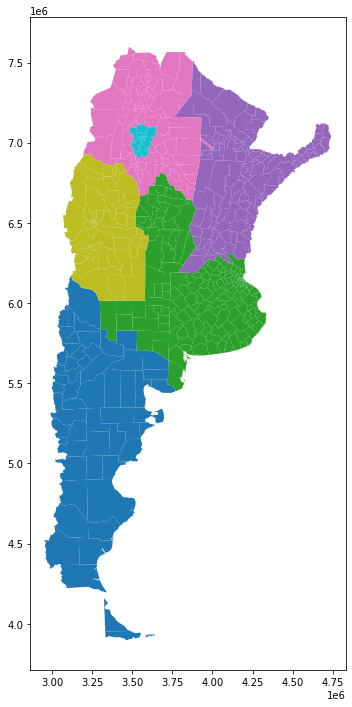

In [24]:
sim5.df.plot(sdec_.y_pred, categorical = True, figsize = (15,12))

In [25]:
ent = sim5
ent.metric.regiones = regiones.values
ent.metric.MI(ent.df,rdos_rgeoda.redcap.values),ent.metric.MI(ent.df,sdec_.y_pred),ent.metric.MI(ent.df,rdos_rgeoda.ae_redcap.values),ent.metric.MI(ent.df,rdos_rgeoda.ae_sk.values),ent.metric.MI(sim4.df,rdos_rgeoda.sk.values)

(0.5289381748327332,
 0.9657291140972092,
 0.5036684758905113,
 0.3641344254309602,
 0.7779398519130899)

ent = sim5
ent.metric.Hg_relat(X, rdos_rgeoda.redcap.values),ent.metric.Hg_relat(X, sdec_.y_pred),ent.metric.Hg_relat(X, rdos_rgeoda.ae_redcap.values),ent.metric.Hg_relat(X, rdos_rgeoda.ae_sk.values),ent.metric.Hg_relat(X, rdos_rgeoda.sk.values)

In [26]:
ent.metric.indice_lq(X, rdos_rgeoda.redcap.values),ent.metric.indice_lq(X, sdec_.y_pred),ent.metric.indice_lq(X, rdos_rgeoda.ae_redcap.values)

(0.958, 0.969, 0.9536666666666667)

In [27]:
sim5.metric.calc_metricas(XX,regiones.values)

,mi,ilq,hgr,sil,cal,dav
0,1.0,0.968667,0.390072,-0.000823,38.420457,0.239249


In [28]:
sim5.metric.calc_metricas(XX, rdos_rgeoda.sk.values)

,mi,ilq,hgr,sil,cal,dav
0,0.77794,0.940333,0.506382,-0.006831,26.380185,0.167889


Cuando agegamos ruido a los modelos ya los métodos que no son espaciales presentan severas dificultades para encontrar la respuesta, presentan resultados muy desordenados.

Los métodos espaciales que se presentan por rgeoda no trabajan mal, el que mejor lo hace es el método skater sin considerar los autoencoders. 

Pero para este caso con mayor variabilidad el método propuesto DEC supera ampliamente a todos los demás. Esto se puede ver visualmente y tambien por el indicador de mutual información. El problema que hay es con las métricas intrínseca. Estas arrojan valores peores que los demás modelos, pero si vemos la salida del resultado real, vemos que son muy similares a estas, lo que está fallando en este caso son las métricas.

### Caso 3

Tomammos una amplitud de 1

In [29]:
np.random.seed(3264)

sim6,l = genera_datos(100,1)

C:\Anaconda3\envs\covid2\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  warnings.warn(message)
C:\Anaconda3\envs\covid2\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  warnings.warn(message)


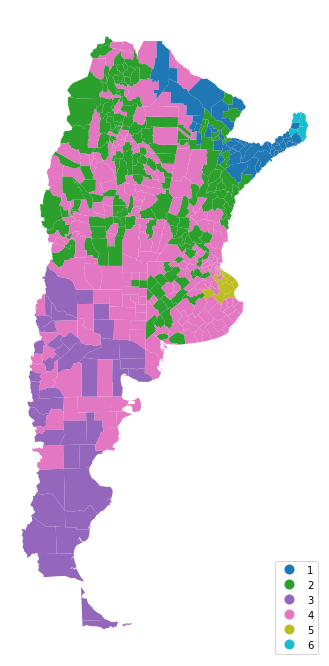

In [30]:
np.random.seed(646)

lista = ['prop1','prop2']
n_enc = 4
sim6.calcular_metodo('aglo_esp', lista, centroides = False,ae = True, n_encoders = n_enc, optimizer = 'adam', loss = 'cosine_similarity')
sim6.mapa('aglo_esp')

In [31]:
ent = sim6
dir_ent = "sim6/"

geoprop = reg.gpd.GeoDataFrame(ent.retornar_dfs(separado = [lista])[0],columns = [l[i][0]+str(l[i][1]) for i in range(len(l))] ,geometry = ent.geo.values)
geoprop.to_file(dir_general+dir_ent+"prop.shp")
geoenco = reg.gpd.GeoDataFrame(ent.enco.predict(ent.retornar_dfs(separado = lista)), columns = ['enco'+str(i) for i in range(n_enc)], geometry = ent.geo.values)
geoenco.to_file(dir_general+dir_ent+"encoders.shp")

C:\Anaconda3\envs\covid2\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
C:\Anaconda3\envs\covid2\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [32]:
rdos_rgeoda = gpd.read_file(dir_general+dir_ent+"rdos_rgeod.shp")
rdos_rgeoda.head()

,enco0,enco1,enco2,enco3,ae_sk,ae_redcap,ae_schc,sk,redcap,geometry
0,2.275977,0.0,1.534266,2.226861,1,1,1,1,1,"POLYGON ((4200350.769 6147470.664, 4201101.267..."
1,1.165836,0.0,2.512023,2.185136,1,1,1,1,1,"POLYGON ((4198043.775 6148577.659, 4198111.775..."
2,2.437452,0.0,0.727416,0.635081,1,1,1,1,1,"POLYGON ((4198450.276 6145157.669, 4198456.277..."
3,1.657424,0.0,1.380935,0.575473,1,1,1,1,1,"POLYGON ((4201672.770 6142869.179, 4201695.770..."
4,1.497364,0.0,2.276701,2.286301,1,1,1,1,1,"POLYGON ((4196342.782 6145516.166, 4196373.783..."


(<AxesSubplot:>, <AxesSubplot:>)

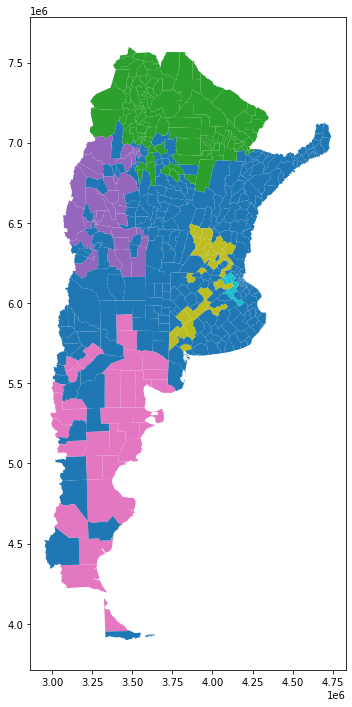

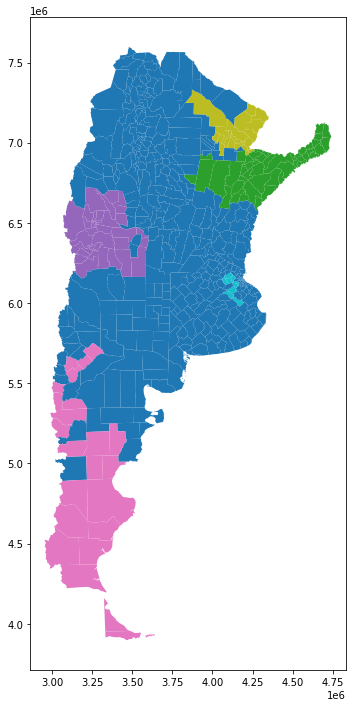

In [33]:
rdos_rgeoda.plot('redcap', categorical = True, figsize = (15,12)),rdos_rgeoda.plot('sk', categorical = True, figsize = (15,12))

In [34]:
lista = ['prop1','prop2']
X = sim6.retornar_dfs(separado = lista)
sdec_ = dc.sdec(6)
XX =np.c_[X[0],X[1]]
sdec_.gen_modelo()
sdec_.train_autoencoder(X, XX)
sdec_.ajustar_modelo(X, sim6.W.sparse)

<AxesSubplot:>

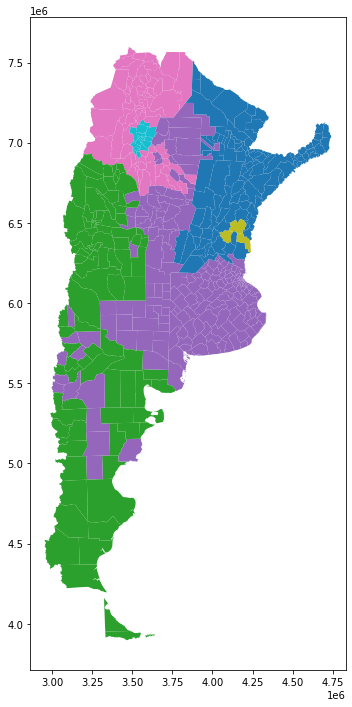

In [35]:
sim6.df.plot(sdec_.y_pred, categorical = True, figsize = (15,12))

In [36]:
ent = sim6
ent.metric.regiones = regiones.values
ent.metric.MI(ent.df,rdos_rgeoda.redcap.values),ent.metric.MI(ent.df,sdec_.y_pred),ent.metric.MI(ent.df,rdos_rgeoda.ae_redcap.values),ent.metric.MI(ent.df,rdos_rgeoda.ae_sk.values),ent.metric.MI(sim4.df,rdos_rgeoda.sk.values)

(0.37287252867429116,
 0.7600037168086736,
 0.336841216936649,
 0.4225882102792614,
 0.40410619909786594)

In [37]:
ent.metric.Hg_relat(X, rdos_rgeoda.redcap.values),ent.metric.Hg_relat(X, sdec_.y_pred),ent.metric.Hg_relat(X, rdos_rgeoda.ae_redcap.values),ent.metric.Hg_relat(X, rdos_rgeoda.ae_sk.values),ent.metric.Hg_relat(X, rdos_rgeoda.sk.values)

(0.6928683696160047,
 0.3522580144996573,
 0.5389672509222722,
 0.5067349760963711,
 0.724504042923021)

In [38]:
ent.metric.indice_lq(X, rdos_rgeoda.redcap.values),ent.metric.indice_lq(X, sdec_.y_pred),ent.metric.indice_lq(X, rdos_rgeoda.ae_redcap.values)

(0.973, 0.965, 0.983)

In [39]:
ent.metric.calc_metricas(XX,regiones.values)

,mi,ilq,hgr,sil,cal,dav
0,1.0,0.965,0.312232,-0.05355,12.796101,0.147019


In [40]:
ent.metric.calc_metricas(XX,sdec_.y_pred)

,mi,ilq,hgr,sil,cal,dav
0,0.760004,0.965,0.352258,-0.19814,10.773908,0.201217


In [41]:
ent.metric.calc_metricas(XX,rdos_rgeoda.sk.values)

,mi,ilq,hgr,sil,cal,dav
0,0.404106,0.979,0.724504,-0.079768,17.81094,0.341751


Con mayor variabilidad los resultados son similares. 

DEC supera ampliamente a los demás, se puede ver con el índice extrínseco de mutual información y visualmente a través del gráfico. El problema vuelven a ser las métricas intrinsecas que son menores ante el mejor resultado, incluso ante el resultado real.


## Covid

In [42]:
e_cov = reg.entorno(covid, ['clasificac','fallecido'],'personas',pipe)

C:\Anaconda3\envs\covid2\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  warnings.warn(message)
C:\Anaconda3\envs\covid2\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  warnings.warn(message)


In [43]:
e_cov.procesar_datos()
param = {'n_clusters' : [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]} #se crean los distintos parametros para probar, en este caso solo de cantidad de grupos
#param = {'n_clusters' : [6]} 
metricas = {'hg': e_cov.metric.Hg_relat, 'ind lq': e_cov.metric.indice_lq} # se crean las metricas. En este caso las que provienen del LQ y es importante que salgan del entorno así buscan bien los datos
param_aglo = reg.copy(param)
param_aglo['connectivity'] = [sim4.W.sparse]

e_cov.agregar_metodo('km', KMeans(), param, metricas)
e_cov.agregar_metodo('aglo', AgglomerativeClustering(), param, metricas)
e_cov.agregar_metodo('aglo_esp', AgglomerativeClustering(), param_aglo, metricas)


In [44]:
df = e_cov.convertir_a_df(e_cov.panel_df, ['clasificac','fallecido'])
e_cov.agregar_data('prop',df.iloc[:,:-1].values/df.personas.values.reshape(-1,1), ajustar = False)
e_cov.agregar_data('prop_clasif',df['clasificac'].values/df.personas.values.reshape(-1,1), ajustar = False)
e_cov.agregar_data('prop_falle',df['fallecido'].values/df.personas.values.reshape(-1,1), ajustar = False)

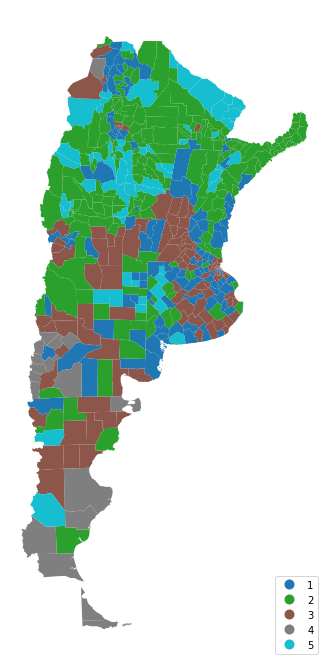

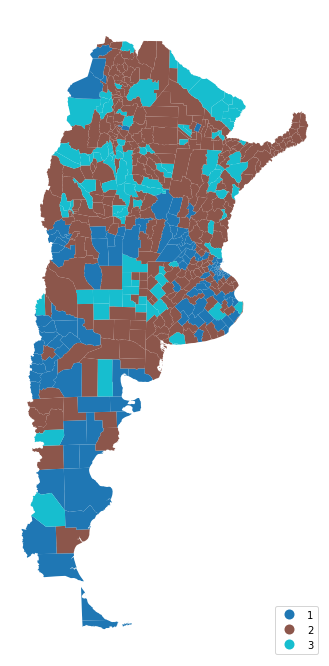

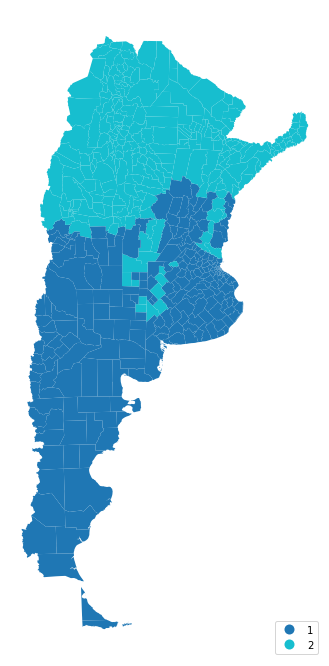

(None, None, None)

In [45]:
np.random.seed(646)

lista = ['prop_clasif','prop_falle']
n_enc = 4

e_cov.calcular_metodo('km', lista, centroides = False,ae = True, n_encoders = n_enc, optimizer = 'adam', loss = 'cosine_similarity')
e_cov.calcular_metodo('aglo', lista, centroides = False,ae = True, n_encoders = n_enc, optimizer = 'adam', loss = 'cosine_similarity')
e_cov.calcular_metodo('aglo_esp', lista, centroides = False,ae = True, n_encoders = n_enc, optimizer = 'adam', loss = 'cosine_similarity')
e_cov.mapa('km'),e_cov.mapa('aglo'),e_cov.mapa('aglo_esp')

In [46]:
periodos = 17
p = np.arange(0,periodos)

l = list(zip(['var1']*periodos,p))
l.extend(list(zip(['var2']*periodos,p)))
l = tuple(l)

In [47]:
geoprop = reg.gpd.GeoDataFrame(e_cov.retornar_dfs(separado = [lista])[0],columns = [l[i][0]+str(l[i][1]) for i in range(len(l))] ,geometry = e_cov.geo.values)
geoprop.to_file("Geodabd/covid/prop.shp")
geoenco = reg.gpd.GeoDataFrame(e_cov.enco.predict(e_cov.retornar_dfs(separado = lista)), columns = ['enco'+str(i) for i in range(n_enc)], geometry = e_cov.geo.values)
geoenco.to_file("Geodabd/covid/encoders.shp")

C:\Anaconda3\envs\covid2\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
C:\Anaconda3\envs\covid2\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [48]:
rdos_rgeoda = gpd.read_file("Geodabd/covid/rdos_rgeod.shp")
rdos_rgeoda.head()

,enco0,enco1,enco2,enco3,ae_sk,ae_redcap,ae_schc,sk,redcap,geometry
0,0.0,0.0,5.727364,0.0,2,2,1,3,3,"POLYGON ((4200350.769 6147470.664, 4201101.267..."
1,0.0,0.0,5.727355,0.0,2,2,1,3,3,"POLYGON ((4198043.775 6148577.659, 4198111.775..."
2,0.0,0.0,5.727340,0.0,2,2,1,3,3,"POLYGON ((4198450.276 6145157.669, 4198456.277..."
3,0.0,0.0,5.727328,0.0,2,2,1,3,3,"POLYGON ((4201672.770 6142869.179, 4201695.770..."
4,0.0,0.0,5.727360,0.0,2,2,1,3,3,"POLYGON ((4196342.782 6145516.166, 4196373.783..."


<AxesSubplot:>

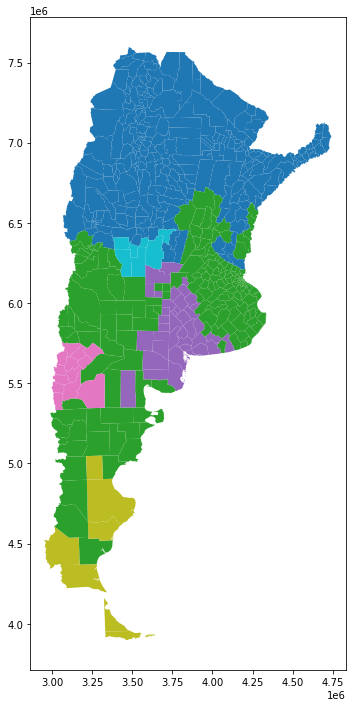

In [49]:
rdos_rgeoda.plot('ae_sk', categorical = True, figsize = (15,12))

<AxesSubplot:>

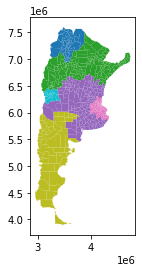

In [50]:
X = e_cov.retornar_dfs(separado = lista)
sdec_ = dc.sdec(6, [17,17])
XX =np.c_[X[0],X[1]]
sdec_.gen_modelo()
sdec_.train_autoencoder(X, XX)
sdec_.ajustar_modelo(X, e_cov.W.sparse)

e_cov.df.plot(sdec_.y_pred, categorical = True)

In [51]:
e_cov.metric.calc_metricas(XX, sdec_.y_pred)

,mi,ilq,hgr,sil,cal,dav
0,NaN,0.42549,0.431226,-0.014748,34.174801,0.322437


In [52]:
e_cov.metric.calc_metricas(XX, rdos_rgeoda.ae_sk.values)

,mi,ilq,hgr,sil,cal,dav
0,NaN,0.337255,0.447268,0.073302,29.496205,0.371628


In [53]:
e_cov.metric.calc_metricas(XX, rdos_rgeoda.ae_redcap.values)

,mi,ilq,hgr,sil,cal,dav
0,NaN,0.337255,0.468697,0.074493,30.406728,0.365362


In [54]:
e_cov.metric.calc_metricas(XX, rdos_rgeoda.redcap.values)

,mi,ilq,hgr,sil,cal,dav
0,NaN,0.386275,0.313947,0.061006,33.64711,0.433478


In [55]:
e_cov.metric.calc_metricas(XX, rdos_rgeoda.sk.values)

,mi,ilq,hgr,sil,cal,dav
0,NaN,0.358824,0.393921,0.023555,29.023918,0.282377


In [56]:
X = e_cov.retornar_dfs(separado = lista)
sdec_ = dc.sdec(23, [17,17])
XX =np.c_[X[0],X[1]]
sdec_.gen_modelo()
sdec_.train_autoencoder(X, XX)
sdec_.ajustar_modelo(X, e_cov.W.sparse)



<AxesSubplot:>

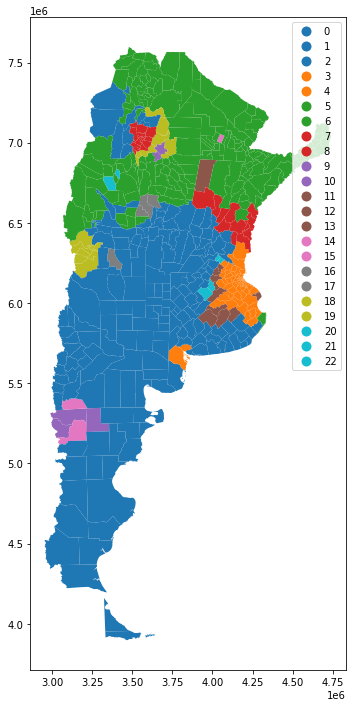

In [57]:
e_cov.df.plot(sdec_.y_pred, categorical = True, figsize = (15,12), legend = True)

In [58]:
e_cov.metric.calc_metricas(XX, sdec_.y_pred)

,mi,ilq,hgr,sil,cal,dav
0,NaN,0.172751,0.842908,-0.264313,7.856174,0.314768


<AxesSubplot:xlabel='mes'>

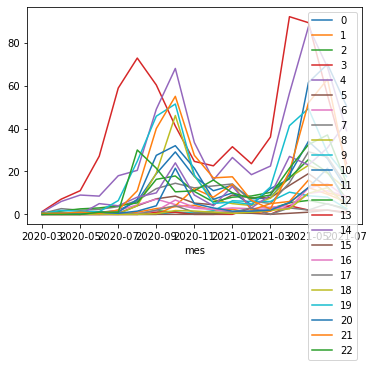

In [59]:
df['fallecido'].groupby(sdec_.y_pred).mean().T.plot()

In [60]:
e_cov.dic['prop'][codiprov.provincia == 'Tucumán'].mean(axis = 0)

array([1.23060632e-05, 9.28149376e-06, 4.13088454e-05, 7.61742906e-05,
       1.00778895e-04, 1.36138943e-03, 6.65566433e-03, 1.52523419e-02,
       9.07026504e-03, 3.46929438e-03, 4.12660903e-03, 2.36446027e-03,
       4.85551060e-03, 1.31861602e-02, 1.73972957e-02, 2.12084237e-02,
       1.44552306e-02, 1.10503829e-06, 4.34169258e-06, 1.48146045e-06,
       5.35864213e-07, 2.17992507e-06, 3.14860329e-05, 1.38748292e-04,
       3.04757086e-04, 1.44385743e-04, 7.47158619e-05, 6.03991371e-05,
       2.99363624e-05, 5.39323005e-05, 1.78395811e-04, 2.94538518e-04,
       2.39595827e-04, 9.91695154e-05])

In [61]:
e_cov.dic['prop'][codiprov.provincia == 'Mendoza'].mean(axis = 0)

array([1.42148684e-05, 5.29715357e-05, 1.97492779e-05, 6.41186395e-05,
       6.45772065e-04, 3.10631482e-03, 9.53324343e-03, 1.32627021e-02,
       5.48839701e-03, 2.06282647e-03, 2.17087772e-03, 1.65730189e-03,
       3.29440055e-03, 1.27689161e-02, 1.52887520e-02, 1.27594154e-02,
       7.53365046e-03, 3.29013920e-06, 1.78028391e-05, 1.21256133e-05,
       2.05996513e-05, 4.49842378e-05, 1.34782597e-04, 2.78677942e-04,
       4.27588473e-04, 1.74084811e-04, 6.65401850e-05, 7.63720708e-05,
       6.66506337e-05, 9.99312204e-05, 3.51439538e-04, 4.73203412e-04,
       3.27350623e-04, 1.54022825e-04])

In [62]:
e_cov.metric.calc_metricas(XX, codiprov.codpcia.values)

,mi,ilq,hgr,sil,cal,dav
0,NaN,0.320972,0.765128,-0.101808,15.926372,0.318453
